baseline.ipynb<br>
.. └ data<br>
.... ├ train.json<br>
.... ├ test.json<br>
.... └ sample_submission.csv<br>

# 사용 패키지

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import random
import math
import copy
import gc
from tqdm import tqdm
from glob import glob
from konlpy.tag import Mecab

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings(action='ignore')

## 랜덤 시드 고정

In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

In [3]:
seed_everything(42)

# 데이터 로드

In [4]:
DIR = "./data/meeting_summary/"
TRAIN_SOURCE = os.path.join(DIR, "train.json")
TEST_SOURCE = os.path.join(DIR, "test.json")

In [5]:
with open(TRAIN_SOURCE) as f:
    TRAIN_DATA = json.loads(f.read())
    
with open(TEST_SOURCE) as f:
    TEST_DATA = json.loads(f.read())

In [6]:
train = pd.DataFrame(columns=['uid', 'title', 'region', 'context', 'summary'])
uid = 1000
for data in TRAIN_DATA:
    for agenda in data['context'].keys():
        context = ''
        for line in data['context'][agenda]:
            context += data['context'][agenda][line]
            context += ' '
        train.loc[uid, 'uid'] = uid
        train.loc[uid, 'title'] = data['title']
        train.loc[uid, 'region'] = data['region']
        train.loc[uid, 'context'] = context[:-1]
        train.loc[uid, 'summary'] = data['label'][agenda]['summary']
        uid += 1

test = pd.DataFrame(columns=['uid', 'title', 'region', 'context'])
uid = 2000
for data in TEST_DATA:
    for agenda in data['context'].keys():
        context = ''
        for line in data['context'][agenda]:
            context += data['context'][agenda][line]
            context += ' '
        test.loc[uid, 'uid'] = uid
        test.loc[uid, 'title'] = data['title']
        test.loc[uid, 'region'] = data['region']
        test.loc[uid, 'context'] = context[:-1]
        uid += 1

In [7]:
train['total'] = train.title + ' ' + train.region + ' ' + train.context
test['total'] = test.title + ' ' + test.region + ' ' + test.context

In [8]:
train.head()

,uid,title,region,context,summary,total
1000,1000,제207회 완주군의회(임시회) 제 1 차 본회의회의록,완주,의석을 정돈하여 주시기 바랍니다. 성원이 되었으므로 제207회 완주군의회 임시회 제...,제207회 완주군의회 임시회 제1차 본회의 개의 선포.,제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 의석을 정돈하여 주시기 ...
1001,1001,제207회 완주군의회(임시회) 제 1 차 본회의회의록,완주,의사팀장 수고하셨습니다. 먼저 의사일정 제1항 제207회 완주군의회 임시회 회기 결...,제207회 완주군의회 임시회 회기는 8월 26일부터 9월 4일까지 10일간으로 가결됨.,제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 의사팀장 수고하셨습니다....
1002,1002,제207회 완주군의회(임시회) 제 1 차 본회의회의록,완주,다음은 의사일정 제2항 제207회 완주군의회 임시회 회의록 서명의원 선출의 건을 상...,제207회 완주군의회 임시회 회의록 서명의원으로 최등원 의원과 박웅배 의원이 선출됨.,제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 다음은 의사일정 제2항 ...
1003,1003,제207회 완주군의회(임시회) 제 1 차 본회의회의록,완주,다음은 의사일정 제3항 본회의 휴회의 건을 상정합니다. 상임의원회 의정활동을 위하여...,8월 27일부터 9월 3일까지 8일간 휴회가 가결됨. 제2차 본회의는 9월 4일 오...,제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 다음은 의사일정 제3항 ...
1004,1004,제251회 완주군의회(제1차 정례회) 제1차 본 회 의 회 의 록,완주,의석을 정돈하여 주시기 바랍니다. 성원이 되었으므로 제251회 완주군의회 제1차 정...,제251회 완주군의회 제1차 정례회 제1차 본회의 개의 선포.,제251회 완주군의회(제1차 정례회) 제1차 본 회 의 회 의 록 완주 의석을 정돈...


In [9]:
train['context'].iloc[0]

'의석을 정돈하여 주시기 바랍니다. 성원이 되었으므로 제207회 완주군의회 임시회 제1차 본회의 개의를 선포합니다. 먼저 의사팀장으로부터 의회 관련 사항에 대한 보고가 있겠습니다. 의사팀장은 보고하여 주시기 바랍니다. 의사팀장 이은미 입니다. 의회관련 사항을 보고 드리겠습니다. 먼저 제207회 완주군의회 임시회 소집경위를 보고 드리겠습니다. 지방자치법 제45조 제2항의 규정에 의거 서남용 의원님 외 4인의 의원님으로부터 임시회 집회 요구가 있어 지난 8월6일 집회 공고를 하고 오늘 집회를 갖게 되었습니다. 다음은 의안접수 및 회부사항입니다. 먼저 의원발의 안건입니다. 완주군의회 의원 의정활동비등 지급에 관한 조례 일부개정 조례안, 완주군 향토문화유산 보호 및 관리 조례안, 완주군 싸움소 육성 지원에 관한 조례안 등 총 3건으로, 해당 상임의원회로 회부 하였습니다. 다음은 완주군수로부터 제출된 안건입니다. 삼례문화예술촌 설치 및 운영조례 일부개정 조례안 등 총 40건으로 해당 상임의원회로 회부하였습니다. 자세한 내용은 배부해 드린 유인물을 참조하여 주시기 바랍니다. 이상 보고를 마치겠습니다.'

In [9]:
train.shape

(2994, 6)

In [10]:
test.head()

,uid,title,region,context,total
2000,2000,제235회 본회의 제1차(2012.06.21.),음성,의석을 정돈하여 주시기 바랍니다. 성원이 되었으므로 지금부터 음성군의회 제235회 ...,제235회 본회의 제1차(2012.06.21.) 음성 의석을 정돈하여 주시기 ...
2001,2001,제235회 본회의 제1차(2012.06.21.),음성,"의사일정 제1항, 음성군의회 제235회 제1차 정례회 회기결정의 건을 상정합니다. ...","제235회 본회의 제1차(2012.06.21.) 음성 의사일정 제1항, 음성군..."
2002,2002,제235회 본회의 제1차(2012.06.21.),음성,"의사일정 제2항, 회의록 서명의원 선출의 건을 상정합니다. 제235회 제1차 정례회...","제235회 본회의 제1차(2012.06.21.) 음성 의사일정 제2항, 회의록..."
2003,2003,제235회 본회의 제1차(2012.06.21.),음성,"의사일정 제3항, 예산결산특별위원회 구성의 건을 상정합니다. 예산결산특별위원회 구성...","제235회 본회의 제1차(2012.06.21.) 음성 의사일정 제3항, 예산결..."
2004,2004,제235회 본회의 제1차(2012.06.21.),음성,"의사일정 제4항, 환경분야 현지확인 특별위원회 구성결의안을 상정합니다. 대표발의하신...","제235회 본회의 제1차(2012.06.21.) 음성 의사일정 제4항, 환경분..."


In [11]:
test.shape

(506, 5)

## 하이퍼파라미터

In [12]:
encoder_len = 500
decoder_len = 50
max_vocab_size = 20000
batch_size = 32
num_layers = 6
d_model = 512
dff = 2048
num_heads = 8
dropout_rate = 0.1
epochs = 20
learning_rate = 1e-4
device = torch.device("cuda:0")

## train, validation 분리

In [13]:
df_train = train.iloc[:-200]
df_val = train.iloc[-200:]

# 토크나이징

In [14]:
class Mecab_Tokenizer():
    def __init__(self, max_length, mode, max_vocab_size=-1):
        self.text_tokenizer = Mecab()
        self.mode = mode
        self.txt2idx = {'pad_':0, 'unk_':1}
        self.idx2txt = {0:'pad_', 1:'unk_'}
        self.max_length = max_length
        self.word_count = {}
        self.max_vocab_size = max_vocab_size
        
        # 띄어쓰기를 찾기 위한 태그 목록
        self.font_blank_tag = [
            '', 'EC', 'EC+JKO', 'EF', 'EP+EC', 'EP+EP+EC', 'EP+ETM', 'EP+ETN+JKO', 'ETM', 'ETN', 'ETN+JKO', 'ETN+JX', 'IC', 'JC', 'JKB', 'JKB+JX', 'JKO',
            'JKQ', 'JKS', 'JX', 'MAG', 'MAG+JX', 'MAG+XSV+EP+EC', 'MAJ','MM', 'MM+EC', 'NNB', 'NNB+JKB', 'NNB+JKO', 'NNB+VCP+EC', 'NNBC', 'NNG', 'NNG+JX+JKO',
            'NNG+VCP+EC', 'NNP', 'NNP+JX', 'NP', 'NP+JKO', 'NP+JKS', 'NP+JX', 'NP+VCP+EC', 'NR', 'SC', 'SF', 'SL', 'SN', 'SSC', 'SSO', 'SY', 'UNKNOWN',
            'VA+EC', 'VA+EC+VX+ETM', 'VA+ETM', 'VA+ETN+JKB+JX', 'VCN+EC', 'VCN+ETM', 'VCP', 'VCP+EC', 'VCP+EP+EC', 'VCP+EP+ETM', 'VCP+ETM', 'VCP+ETN',
            'VV+EC', 'VV+EC+JX', 'VV+EC+VX+EC', 'VV+EC+VX+ETM', 'VV+EP+EC', 'VV+EP+ETM', 'VV+ETM', 'VV+ETN', 'VX+EC', 'VX+EC+VX+EP+EC', 'VX+EP+ETM',
            'VX+ETM', 'XPN', 'XR', 'XSA+EC', 'XSA+EC+VX+ETM', 'XSA+ETM', 'XSN', 'XSV+EC', 'XSV+EP+EC', 'XSV+ETM', 'XSV+ETN', 'XSV+JKO'
        ]
        self.back_blank_tag = [
            '', 'IC', 'MAG', 'MAG+JX', 'MAG+XSV+EP+EC', 'MAJ', 'MM', 'MM+EC', 'NNB', 'NNB+JKB', 'NNB+VCP', 'NNB+VCP+EC', 'NNB+VCP+EF', 'NNBC', 'NNBC+VCP+EC',
            'NNG', 'NNG+JC', 'NNG+JX+JKO', 'NNG+VCP', 'NNG+VCP+EC', 'NNG+VCP+ETM', 'NNP', 'NNP+JX', 'NP', 'NP+JKG', 'NP+JKO', 'NP+JKS', 'NP+JX', 'NP+VCP+EC', 'NP+VCP+EF',
            'NR', 'SC', 'SL', 'SN', 'SSC', 'SSO', 'SY', 'VA', 'VA+EC', 'VA+EC+VX+ETM', 'VA+EF', 'VA+ETM', 'VA+ETN', 'VA+ETN+JKB+JX', 'VCN', 'VCN+EC', 'VCN+EF', 'VCN+ETM',
            'VCN+ETN', 'VCP', 'VCP+EF', 'VV', 'VV+EC', 'VV+EC+JX', 'VV+EC+VX', 'VV+EC+VX+EC', 'VV+EC+VX+EF', 'VV+EC+VX+EP+EC', 'VV+EC+VX+ETM', 'VV+EF', 'VV+EP', 'VV+EP+EC',
            'VV+EP+ETM', 'VV+ETM', 'VV+ETN', 'VV+ETN+VCP+EF', 'VX', 'VX+ETM', 'XPN', 'XR', 'XSA+ETN+VCP+EF', 'XSN'
        ]
        
    def morpheme(self, sentence_list):
        new_sentence = []
        for i, sentence in tqdm(enumerate(sentence_list)):
            temp = []
            if self.mode == 'dec':
                temp.append('sos_')
            for t in self.text_tokenizer.pos(sentence):
                temp.append('_'.join(t))
            if self.mode == 'dec':
                temp.append('eos_')
            new_sentence.append(' '.join(temp))
            
        return new_sentence
    
    def fit(self, sentence_list):
        for sentence in tqdm(sentence_list):
            for word in sentence.split(' '):
                try:
                    self.word_count[word] += 1
                except:
                    self.word_count[word] = 1
        self.word_count = dict(sorted(self.word_count.items(), key=self.sort_target, reverse=True))
        
        self.txt2idx = {'pad_':0, 'unk_':1}
        self.idx2txt = {0:'pad_', 1:'unk_'}
        if self.max_vocab_size == -1:
            for i, word in enumerate(list(self.word_count.keys())):
                self.txt2idx[word]=i+2
                self.idx2txt[i+2]=word
        else:
            for i, word in enumerate(list(self.word_count.keys())[:self.max_vocab_size]):
                self.txt2idx[word]=i+2
                self.idx2txt[i+2]=word
        
    def sort_target(self, x):
        return x[1]
            
    def txt2token(self, sentence_list):
        tokens = []
        for sentence in tqdm(sentence_list):
            token = [0]*self.max_length
            for i, w in enumerate(sentence.split(' ')):
                if i == self.max_length:
                    break
                try:
                    token[i] = self.txt2idx[w]
                except:
                    token[i] = self.txt2idx['unk_']
            tokens.append(token)
        return np.array(tokens)
    
    def convert(self, token):
        sentence = []
        for j, i in enumerate(token):
            if self.mode == 'enc':
                if i != self.txt2idx['pad_']:
                    sentence.append(self.idx2txt[i].split('_')[0])
            elif self.mode == 'dec':
                if i == self.txt2idx['eos_'] or i == self.txt2idx['pad_']:
                    break
                elif i != 0:
                    sentence.append(self.idx2txt[i].split('_')[0])
                    # 앞뒤 태그를 확인하여 띄어쓰기 추가
                    if self.idx2txt[i].split('_')[1] in self.font_blank_tag:
                        try:
                            if self.idx2txt[token[j+1]].split('_')[1] in self.back_blank_tag:
                                sentence.append(' ')
                        except:
                            pass
        sentence = "".join(sentence)
        if self.mode == 'enc':
            sentence = sentence[:-1]
        elif self.mode == 'dec':
            sentence = sentence[3:-1]
            
        return sentence

In [15]:
src_tokenizer = Mecab_Tokenizer(encoder_len, mode='enc', max_vocab_size=max_vocab_size)
tar_tokenizer = Mecab_Tokenizer(decoder_len, mode='dec', max_vocab_size=max_vocab_size)

In [16]:
train_src = src_tokenizer.morpheme(df_train.total)
val_src = src_tokenizer.morpheme(df_val.total)
test_src = src_tokenizer.morpheme(test.total)

train_tar = tar_tokenizer.morpheme(df_train.summary)
val_tar = tar_tokenizer.morpheme(df_val.summary)

2794it [00:06, 419.01it/s]
200it [00:00, 495.96it/s]
506it [00:01, 401.71it/s]
2794it [00:00, 7420.44it/s]
200it [00:00, 9636.76it/s]


train_src_max_len : 6476


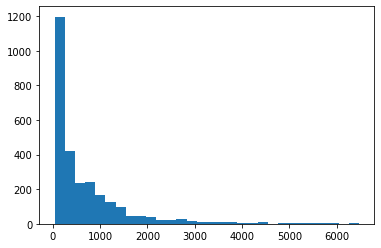

train_tar_max_len : 342


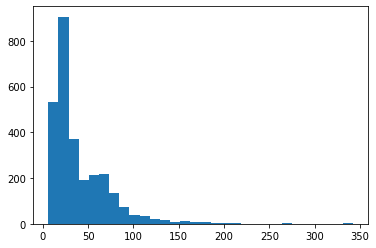

In [17]:
train_src_len = []
for m in train_src:
    m_len = len(m.split(' '))
    train_src_len.append(m_len)
print('train_src_max_len :', max(train_src_len))
plt.hist(train_src_len, bins=30)
plt.show()

train_tar_len = []
for m in train_tar:
    m_len = len(m.split(' '))
    train_tar_len.append(m_len)
print('train_tar_max_len :', max(train_tar_len))
plt.hist(train_tar_len, bins=30)
plt.show()

In [18]:
src_tokenizer.fit(train_src)
tar_tokenizer.fit(train_tar)

100%|██████████| 2794/2794 [00:00<00:00, 113657.51it/s]


In [19]:
train_src_tokens = src_tokenizer.txt2token(train_src)
val_src_tokens = src_tokenizer.txt2token(val_src)
test_src_tokens = src_tokenizer.txt2token(test_src)

train_tar_tokens = tar_tokenizer.txt2token(train_tar)
val_tar_tokens = tar_tokenizer.txt2token(val_tar)

100%|██████████| 200/200 [00:00<00:00, 112947.46it/s]


In [20]:
input_vocab_size = len(src_tokenizer.txt2idx)
target_vocab_size = len(tar_tokenizer.txt2idx)

In [21]:
input_vocab_size, target_vocab_size

(20002, 4877)

In [22]:
df_train.summary.iloc[0]

'제207회 완주군의회 임시회 제1차 본회의 개의 선포.'

In [23]:
train_tar_tokens[0], tar_tokenizer.convert(train_tar_tokens[0])

(array([   3,    8, 1131,   19,   42,   21,   24,    8,   35,   25,   49,
           5,   44,    5,   52,    2,    4,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]),
 ' 제 207 회 완주군 의회 임시회 제 1 차 본회의개의선포.')

# 데이터셋

In [24]:
class CustomDataset(Dataset):
    def __init__(self, src_tokens, tar_tokens, mode='train'):
        self.mode = mode
        self.src_tokens = src_tokens
        if self.mode == 'train':
            self.tar_tokens = tar_tokens
            
    def __len__(self):
        return len(self.src_tokens)
    
    def __getitem__(self, i):
        src_token = self.src_tokens[i]
        if self.mode == 'train':
            tar_token = self.tar_tokens[i]
            return {
                'src_token' : torch.tensor(src_token, dtype=torch.long),
                'tar_token' : torch.tensor(tar_token, dtype=torch.long),
            }
        else:
            return {
                'src_token' : torch.tensor(src_token, dtype=torch.long)
            }

In [25]:
train_dataset = CustomDataset(train_src_tokens, train_tar_tokens)
val_dataset = CustomDataset(val_src_tokens, val_tar_tokens)
test_dataset = CustomDataset(test_src_tokens, None, 'test')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=1, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=1, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=1, shuffle=False)

# 모델 Transformer

https://www.tensorflow.org/text/tutorials/transformer 를 pytorch코드로 수정하여 작성하였습니다.

In [26]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [27]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return torch.tensor(pos_encoding, dtype=torch.float32)

In [28]:
def create_padding_mask(seq):
    seq = torch.tensor(torch.eq(seq, 0), dtype=torch.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    seq = seq.unsqueeze(1).unsqueeze(2)
    return seq  # (batch_size, 1, 1, seq_len)

In [29]:
def create_look_ahead_mask(size):
    mask = torch.ones(size, size).triu(diagonal=1)
    return mask  # (seq_len, seq_len)

In [30]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = torch.matmul(q, torch.transpose(k, -2, -1))  # (..., seq_len_q, seq_len_k)
    
    # scale matmul_qk
    dk = k.size()[-1]
    scaled_attention_logits = matmul_qk / math.sqrt(dk)
    
    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = torch.nn.functional.softmax(scaled_attention_logits, dim=-1)  # (..., seq_len_q, seq_len_k)

    output = torch.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [31]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
    print('Attention weights are:')
    print(temp_attn)
    print('Output is:')
    print(temp_out)

In [32]:
np.set_printoptions(suppress=True)

temp_k = torch.tensor([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=torch.float32)  # (4, 3)

temp_v = torch.tensor([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=torch.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = torch.tensor([[0, 10, 0]], dtype=torch.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tensor([[8.4333e-26, 1.0000e+00, 8.4333e-26, 8.4333e-26]])
Output is:
tensor([[1.0000e+01, 9.2766e-25]])


In [33]:
temp_q = torch.tensor([[10, 10, 0]], dtype=torch.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tensor([[5.0000e-01, 5.0000e-01, 4.2166e-26, 4.2166e-26]])
Output is:
tensor([[5.5000e+00, 4.6383e-25]])


In [34]:
temp_q = torch.tensor([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=torch.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tensor([[4.2166e-26, 4.2166e-26, 5.0000e-01, 5.0000e-01],
        [8.4333e-26, 1.0000e+00, 8.4333e-26, 8.4333e-26],
        [5.0000e-01, 5.0000e-01, 4.2166e-26, 4.2166e-26]])
Output is:
tensor([[5.5000e+02, 5.5000e+00],
        [1.0000e+01, 9.2766e-25],
        [5.5000e+00, 4.6383e-25]])


In [35]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)

        self.wo = nn.Linear(d_model, d_model)
        
    def forward(self, v, k, q, mask):
        batch_size = q.size()[0]
        
        q = self.wq(q).view(batch_size, -1, self.num_heads, self.depth).transpose(1, 2)
        k = self.wk(k).view(batch_size, -1, self.num_heads, self.depth).transpose(1, 2)
        v = self.wv(v).view(batch_size, -1, self.num_heads, self.depth).transpose(1, 2)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        scaled_attention = scaled_attention.transpose(1,2).contiguous().view(batch_size, -1, self.num_heads * self.depth)
                
        output = self.wo(scaled_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [36]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = torch.rand(1, 60, 512)  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(torch.Size([1, 60, 512]), torch.Size([1, 8, 60, 60]))

In [37]:
class FFN(nn.Module):
    def __init__(self, d_model, dff):
        super(FFN, self).__init__()
        self.layer1 = nn.Linear(d_model, dff)
        self.activation = nn.ReLU()
        self.fc = nn.Linear(dff, d_model)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.fc(x)

        return x

In [38]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, maximum_position_encoding, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = FFN(d_model, dff)
        
        self.layernorm1 = nn.LayerNorm([maximum_position_encoding, d_model])
        self.layernorm2 = nn.LayerNorm([maximum_position_encoding, d_model])
        
        self.dropout1 = nn.Dropout(rate)
        self.dropout2 = nn.Dropout(rate)


    def forward(self, x, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [39]:
sample_encoder_layer = EncoderLayer(512, 8, 2048, encoder_len)

sample_encoder_layer_output = sample_encoder_layer(
    torch.rand(64, encoder_len, 512), None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

torch.Size([64, 500, 512])

In [40]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, maximum_position_encoding, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = FFN(d_model, dff)
        
        self.dropout1 = nn.Dropout(rate)
        self.dropout2 = nn.Dropout(rate)
        self.dropout3 = nn.Dropout(rate)
        
        self.layernorms1 = nn.ModuleList([copy.deepcopy(nn.LayerNorm([i+1, d_model])) for i in range(maximum_position_encoding)])
        self.layernorms2 = nn.ModuleList([copy.deepcopy(nn.LayerNorm([i+1, d_model])) for i in range(maximum_position_encoding)])
        self.layernorms3 = nn.ModuleList([copy.deepcopy(nn.LayerNorm([i+1, d_model])) for i in range(maximum_position_encoding)])

    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorms1[x.size(1)-1](attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorms2[x.size(1)-1](attn2 + out1)  # (batch_size, target_seq_len, d_model)
        
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorms3[x.size(1)-1](ffn_output + out2)  # (batch_size, target_seq_len, d_model)
        
        return out3, attn_weights_block1, attn_weights_block2

In [41]:
sample_decoder_layer = DecoderLayer(512, 8, 2048, decoder_len)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    torch.rand(64, decoder_len, 512), sample_encoder_layer_output,
    None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

torch.Size([64, 50, 512])

In [42]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [43]:
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, device, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model).to(device)
        
        self.dec_layers = clones(EncoderLayer(d_model, num_heads, dff, maximum_position_encoding, rate), num_layers)
        self.dropout = nn.Dropout(rate)

    def forward(self, x, mask, enc_output=None):
        if enc_output == None:
            seq_len = x.size()[1]
            attention_weights = {}
            x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
            x *= torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
            x += self.pos_encoding[:, :seq_len, :]
            x = self.dropout(x)
            for i in range(self.num_layers):
                x = self.dec_layers[i](x, mask)
        else:
            x = enc_output
            
        return x

In [44]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=input_vocab_size,
                         maximum_position_encoding=encoder_len,
                         device='cpu')

temp_input = torch.randint(low=0, high=input_vocab_size, size=(64, encoder_len))

sample_encoder_output = sample_encoder(temp_input, mask=None, enc_output=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

torch.Size([64, 500, 512])


In [45]:
class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, device, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = nn.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model).to(device)
        
        self.dec_layers = clones(DecoderLayer(d_model, num_heads, dff, maximum_position_encoding, rate), num_layers)
        self.dropout = nn.Dropout(rate)
        
    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        seq_len = x.size()[1]
        attention_weights = {}
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
            
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [46]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=target_vocab_size,
                         maximum_position_encoding=decoder_len,
                         device='cpu')

temp_input = torch.randint(low=0, high=target_vocab_size, size=(64, decoder_len))

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(torch.Size([64, 50, 512]), torch.Size([64, 8, 50, 500]))

In [47]:
class Transformer(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, device, rate=0.1):
        super().__init__()
        self.device = device
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                                 input_vocab_size, pe_input, device, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, pe_target, device, rate)

        self.final_layer = nn.Linear(d_model, target_vocab_size)

    def forward(self, inputs):
        inp, tar, enc_output = inputs

        enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)

        enc_output = self.encoder(inp, enc_padding_mask, enc_output)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights, enc_output

    def create_masks(self, inp, tar):
        # Encoder padding mask
        enc_padding_mask = create_padding_mask(inp)

        # Used in the 2nd attention block in the decoder.
        # This padding mask is used to mask the encoder outputs.
        dec_padding_mask = create_padding_mask(inp)

        # Used in the 1st attention block in the decoder.
        # It is used to pad and mask future tokens in the input received by
        # the decoder.
        look_ahead_mask = create_look_ahead_mask(tar.size(1))
        dec_target_padding_mask = create_padding_mask(tar)
        look_ahead_mask = torch.maximum(dec_target_padding_mask.to(self.device), look_ahead_mask.to(self.device))

        return enc_padding_mask, look_ahead_mask, dec_padding_mask

In [48]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=input_vocab_size, target_vocab_size=target_vocab_size,
    pe_input=encoder_len, pe_target=decoder_len, device='cpu')

temp_input = torch.randint(low=0, high=input_vocab_size, size=(64, encoder_len))
temp_target = torch.randint(low=0, high=target_vocab_size, size=(64, decoder_len))

fn_out, _, _ = sample_transformer([temp_input, temp_target, None])

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

torch.Size([64, 50, 4877])

In [49]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=input_vocab_size,
    target_vocab_size=target_vocab_size,
    pe_input=encoder_len,
    pe_target=decoder_len-1,
    device=device,
    rate=dropout_rate
)

transformer = transformer.to(device)

# 옵티마이저, 손실함수

In [50]:
optimizer = torch.optim.Adam(transformer.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

## 손실함수 및 평가함수 정의

In [51]:
def loss_function(real, pred):
    mask = torch.logical_not(torch.eq(real, 0))
    loss_ = criterion(pred.permute(0,2,1), real)
    mask = torch.tensor(mask, dtype=loss_.dtype)
    loss_ = mask * loss_

    return torch.sum(loss_)/torch.sum(mask)

def accuracy_function(real, pred):
    accuracies = torch.eq(real, torch.argmax(pred, dim=2))
    mask = torch.logical_not(torch.eq(real, 0))
    accuracies = torch.logical_and(mask, accuracies)
    accuracies = torch.tensor(accuracies, dtype=torch.float32)
    mask = torch.tensor(mask, dtype=torch.float32)
    
    return torch.sum(accuracies)/torch.sum(mask)

## 학습 정의

In [52]:
def train_step(batch_item, epoch, batch, training):
    src = batch_item['src_token'].to(device)
    tar = batch_item['tar_token'].to(device)
    
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    if training is True:
        transformer.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output, _, _ = transformer([src, tar_inp, None])
            loss = loss_function(tar_real, output)
        acc = accuracy_function(tar_real, output)
        loss.backward()
        optimizer.step()
        lr = optimizer.param_groups[0]["lr"]
        return loss, acc, round(lr, 10)
    else:
        transformer.eval()
        with torch.no_grad():
            output, _, _ = transformer([src, tar_inp, None])
            loss = loss_function(tar_real, output)
        acc = accuracy_function(tar_real, output)
        return loss, acc

## 학습

In [53]:
loss_plot, val_loss_plot = [], []
acc_plot, val_acc_plot = [], []

for epoch in range(epochs):
    gc.collect()
    total_loss, total_val_loss = 0, 0
    total_acc, total_val_acc = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc, lr = train_step(batch_item, epoch, batch, training)
        total_loss += batch_loss
        total_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'LR' : lr,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'Total ACC' : '{:06f}'.format(total_acc/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    acc_plot.append(total_acc/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, epoch, batch, training)
        total_val_loss += batch_loss
        total_val_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Total Val ACC' : '{:06f}'.format(total_val_acc/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    val_acc_plot.append(total_val_acc/(batch+1))

88it [00:15,  5.71it/s, Epoch=1, LR=0.0001, Loss=3.466304, Total Loss=3.972029, Total ACC=0.158188]
7it [00:00,  7.91it/s, Epoch=1, Val Loss=6.593642, Total Val Loss=3.168485, Total Val ACC=0.322829]
88it [00:15,  5.77it/s, Epoch=2, LR=0.0001, Loss=1.846326, Total Loss=2.493635, Total ACC=0.400300]
7it [00:00,  7.98it/s, Epoch=2, Val Loss=6.191784, Total Val Loss=2.658662, Total Val ACC=0.424855]
88it [00:15,  5.76it/s, Epoch=3, LR=0.0001, Loss=1.743453, Total Loss=2.115055, Total ACC=0.470134]
7it [00:00,  8.07it/s, Epoch=3, Val Loss=5.950694, Total Val Loss=2.425170, Total Val ACC=0.466345]
88it [00:15,  5.71it/s, Epoch=4, LR=0.0001, Loss=2.999063, Total Loss=1.911702, Total ACC=0.502446]
7it [00:00,  8.09it/s, Epoch=4, Val Loss=5.798476, Total Val Loss=2.294058, Total Val ACC=0.487002]
88it [00:15,  5.70it/s, Epoch=5, LR=0.0001, Loss=0.940769, Total Loss=1.749979, Total ACC=0.531091]
7it [00:00,  7.83it/s, Epoch=5, Val Loss=5.741198, Total Val Loss=2.215653, Total Val ACC=0.499172]


## 학습 결과

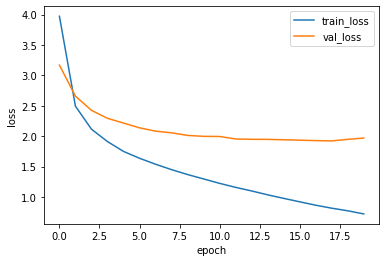

In [54]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

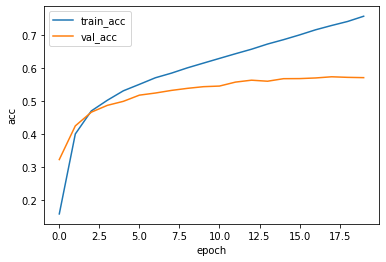

In [55]:
plt.plot(acc_plot, label='train_acc')
plt.plot(val_acc_plot, label='val_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.show()

## 추론

In [56]:
def evaluate(tokens):
    transformer.to(device)
    decoder_input = torch.tensor([tar_tokenizer.txt2idx['sos_']] * tokens.size(0), dtype=torch.long).to(device)
    output = decoder_input.unsqueeze(1).to(device)
    enc_output = None
    for i in range(decoder_len-1):        
        # predictions.shape == (batch_size, seq_len, vocab_size)
        with torch.no_grad():
            predictions, attention_weights, enc_output = transformer([tokens, output, enc_output])
        
        # select the last token from the seq_len dimension
        predictions_ = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
        
        predicted_id = torch.tensor(torch.argmax(predictions_, axis=-1), dtype=torch.int32)
        
        output = torch.cat([output, predicted_id], dim=-1)
    output = output.cpu().numpy()
    
    summary_list = []
    token_list = []
    for token in output:
        summary = tar_tokenizer.convert(token)
        summary_list.append(summary)
        token_list.append(token)
    return summary_list, token_list

In [57]:
tqdm_dataset = tqdm(enumerate(val_dataloader))
preds = []
tokens = []
for batch, batch_item in tqdm_dataset:
    output = evaluate(batch_item['src_token'].to(device))
    preds.extend(output[0])
    tokens.extend(output[1])

7it [00:04,  1.52it/s]


In [58]:
for i, (a, p) in enumerate(zip(df_val.summary, preds)):
    print('정답 :', a)
    print('예측 :', p)
    print('=================================================================================')
    if i == 10:
        break

정답 : 음성군 경로당 지원 조례 일부개정조례안은 경로당 이용에 대한 여건 및 특수성에 따라 기존 미등록 경로당 등록기준을 완화하고, 경로당 양곡 지원에 대한 근거를 마련하는 등 경로당 이용 어르신들의 건강증진 및 복지향상에 기여하기 위해 개정함. 해당 안건은 가결되었음.
예측 :  음성군 노인 종합 복지 관 설치 및 운영 조례 일부 개정 조례 안은 < 장애인 복지 법 >의개정에 따라 상위 법령에 따른 장애인 복지 법 >에 따라 음성군의일부를 조례를 일부 개정하고자 제정함. 해
정답 : 음성군 군세 징수 조례 일부개정조례안과 2019년 재산세 도시지역분 적용대상 지역 고시안은 <음성군 행정기구 설치 조례>가 2019년 1월 1일 전부개정됨에 따라 변경된 사항을 조례에 반영하기 위해 제정함. 해당 안건은 가결되었음.
예측 :  음성군 지역 혁신 협의회 운영 조례 안은 음성군의지역 발전에 대한 지역 발전에 대한 지역 발전에 대한 지역 발전에 대한 음성군의원활한 사항을 조례로 정하고자 제정하였으며 , 해당 안건은 가결됨. 음성군 지역 경
정답 : 음성군 폐기물 관리 조례 일부개정조례안은 쓰레기처리비 대비 수수료 수입비율인 주민부담율이 낮아 청소행정의 건전 재정을 저해하고 불법반입 폐기물이 증가하는 문제가 있어 지역 실정에 맞도록 쓰레기 종량제 수수료를 조정하고자 제정함. 해당 안건은 가결 되었음.
예측 :  음성군 지역 건설 산업 활성 화를 위해 음성군의질 향상 및 운영 조례 일부 개정 조례 안은 < 지방 자치 단체의개정과 지역 경제 활성 화에 따라 지역 경제 활성 화를 조례의안은 < 지방 자치 단체의안
정답 : 음성군 농업기계 사후관리 출장비용 지원 조례안은 음성군 농업인의 농업생산성 향상과 경영 개선, 기계화 영농 편의 등을 제공하고 농업기계 안전사용을 도모하기 위해 제정함. 해당 안건은 가결되었음.
예측 :  음성군 노인 종합 복지 관 설치 및 운영 조례 안은 음성군의질을 위해 제정되었음. 해당 안건은 가결됨.
정답 : 일반농산어촌개발사업 공유재산 시설물 관리

## 제출

In [59]:
tqdm_dataset = tqdm(enumerate(test_dataloader))
preds = []
tokens = []
for batch, batch_item in tqdm_dataset:
    output = evaluate(batch_item['src_token'].to(device))
    preds.extend(output[0])
    tokens.extend(output[1])

16it [00:10,  1.53it/s]


In [60]:
submission = pd.read_csv('data/sample_submission.csv')

In [61]:
submission['summary'] = preds

In [62]:
submission.head()

,uid,summary
0,id_2000-AGENDA_1,제 173 회 제 1 차 정례회 제 1 차 본회의개의선포 . 금번 제 1 차 본회...
1,id_2000-AGENDA_2,제 279 회 음성군 의회 제 1 차 정례회의회기는 2012 년 6 월 15 일부...
2,id_2000-AGENDA_3,"제 279 회 제 1 차 정례회 회의록 서명 의원으로 이한철 의원 , 정태완 의원..."
3,id_2000-AGENDA_4,"예산 결산 특별 위원회 위원은 이한철 의원 , 정태완 의원 , 남궁유 의원 , 조..."
4,id_2000-AGENDA_5,주요 사업 현지 확인 특별 위원회 구성 결의안은 6 월 30 일부터 6 월 1 일...


In [63]:
submission.to_csv('dacon_baseline.csv', index=False)

제출 API 사용법 => https://dacon.io/forum/403557

In [64]:
from dacon_submit_api import dacon_submit_api 

result = dacon_submit_api.post_submission_file(
    'dacon_baseline.csv', 
    '개인 Token', 
    '235813',
    'BASELINE', 
    'DACON_Baseline'
)